Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 📝 Agent Evaluation


**Welcome to Day 4 of the Kaggle 5-day Agents course!**

In the previous notebook, we explored how to implement Observability in AI agents. This approach is primarily **reactive**; it comes into play after an issue has surfaced, providing the necessary data to debug and understand the root cause.

In this notebook, we'll complement those observability practices with a **proactive** approach using **Agent Evaluation.** By continuously evaluating our agent's performance, we can catch any quality degradations much earlier!

```
                            Observability + Agent Evaluation
                            (reactive)      (proactive)
```

## **What is Agent Evaluation?**

It is the systematic process of testing and measuring how well an AI agent performs across different scenarios and quality dimensions.


## **🤖 The story**

You've built a home automation agent. It works perfectly in your tests, so you launch it confidently...


* **Week 1:** 🚨 "Agent turned on the fireplace when I asked for lights!"
* **Week 2:** 🚨 "Agent won't respond to commands in the guest room!"
* **Week 3:** 🚨 "Agent gives rude responses when devices are unavailable!"

**The Problem:** `Standard testing ≠ Evaluation`

Agents are different from traditional software:
- They are non-deterministic
- Users give unpredictable, ambiguous commands
- Small prompt changes cause dramatic behavior shifts and different tool calls 

To accommodate all these differences, agents need systematic evaluation, not just "happy path" testing. **Which means assessing the agent's entire decision-making process - including the final response and the path it took to get the response (trajectory)!**

By the end of this notebook, you will be able to:

* ✅ Understand what agent evaluation is and how to use it
* ✅ Run evaluations and analyze results directly in the ADK web UI
* ✅ Detect regression in the agent's performance over a period of time
* ✅ Understand and create the necessary evaluation files (`*.test.json`, `*.evalset.json`, `test_config.json`).


## ‼️ Please Read

> ❌ **ℹ️ Note: No submission required!**
> This notebook is for your hands-on practice and learning only. You **do not** need to submit it anywhere to complete the course.

> ⏸️ **Note:**  When you first start the notebook via running a cell you might see a banner in the notebook header that reads **"Waiting for the next available notebook"**. The queue should drop rapidly; however, during peak bursts you might have to wait a few minutes.

> ❌ **Note:** Avoid using the **Run all** cells command as this can trigger a QPM limit resulting in 429 errors when calling the backing model. Suggested flow is to run each cell in order - one at a time. [See FAQ on 429 errors for more information.](https://www.kaggle.com/code/kaggle5daysofai/day-0-troubleshooting-and-faqs)

**For help: Ask questions on the [Kaggle Discord](https://discord.com/invite/kaggle) server.**

---
## ⚙️ Section 1: Setup

Before we begin our evaluation journey, let's set up our environment.

### 1.1: Install dependencies

The Kaggle Notebooks environment includes a pre-installed version of the [google-adk](https://google.github.io/adk-docs/) library for Python and its required dependencies, so you don't need to install additional packages in this notebook.

To install and use ADK in your own Python development environment outside of this course, you can do so by running:

```
pip install google-adk
```

### 🔑 1.2: Configure your Gemini API Key

This notebook uses the [Gemini API](https://ai.google.dev/gemini-api/), which requires an API key.

**1. Get your API key**

If you don't have one already, create an [API key in Google AI Studio](https://aistudio.google.com/app/api-keys).

**2. Add the key to Kaggle Secrets**

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

1. In the top menu bar of the notebook editor, select `Add-ons` then `Secrets`.
2. Create a new secret with the label `GOOGLE_API_KEY`.
3. Paste your API key into the "Value" field and click "Save".
4. Ensure that the checkbox next to `GOOGLE_API_KEY` is selected so that the secret is attached to the notebook.

**3. Authenticate in the notebook**

Run the cell below to access the `GOOGLE_API_KEY` you just saved and set it as an environment variable for the notebook to use:

In [1]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Setup and authentication complete.


### 💻 1.3: Set up proxy and tunneling

We'll use a proxy to access the ADK web UI from within the Kaggle Notebooks environment. If you are running this outside the Kaggle environment, you don't need to do this.

In [2]:
from IPython.core.display import display, HTML
from jupyter_server.serverapp import list_running_servers


# Gets the proxied URL in the Kaggle Notebooks environment
def get_adk_proxy_url():
    PROXY_HOST = "https://kkb-production.jupyter-proxy.kaggle.net"
    ADK_PORT = "8000"

    servers = list(list_running_servers())
    if not servers:
        raise Exception("No running Jupyter servers found.")

    baseURL = servers[0]["base_url"]

    try:
        path_parts = baseURL.split("/")
        kernel = path_parts[2]
        token = path_parts[3]
    except IndexError:
        raise Exception(f"Could not parse kernel/token from base URL: {baseURL}")

    url_prefix = f"/k/{kernel}/{token}/proxy/proxy/{ADK_PORT}"
    url = f"{PROXY_HOST}{url_prefix}"

    styled_html = f"""
    <div style="padding: 15px; border: 2px solid #f0ad4e; border-radius: 8px; background-color: #fef9f0; margin: 20px 0;">
        <div style="font-family: sans-serif; margin-bottom: 12px; color: #333; font-size: 1.1em;">
            <strong>⚠️ IMPORTANT: Action Required</strong>
        </div>
        <div style="font-family: sans-serif; margin-bottom: 15px; color: #333; line-height: 1.5;">
            The ADK web UI is <strong>not running yet</strong>. You must start it in the next cell.
            <ol style="margin-top: 10px; padding-left: 20px;">
                <li style="margin-bottom: 5px;"><strong>Run the next cell</strong> (the one with <code>!adk web ...</code>) to start the ADK web UI.</li>
                <li style="margin-bottom: 5px;">Wait for that cell to show it is "Running" (it will not "complete").</li>
                <li>Once it's running, <strong>return to this button</strong> and click it to open the UI.</li>
            </ol>
            <em style="font-size: 0.9em; color: #555;">(If you click the button before running the next cell, you will get a 500 error.)</em>
        </div>
        <a href='{url}' target='_blank' style="
            display: inline-block; background-color: #1a73e8; color: white; padding: 10px 20px;
            text-decoration: none; border-radius: 25px; font-family: sans-serif; font-weight: 500;
            box-shadow: 0 2px 5px rgba(0,0,0,0.2); transition: all 0.2s ease;">
            Open ADK Web UI (after running cell below) ↗
        </a>
    </div>
    """

    display(HTML(styled_html))

    return url_prefix


print("✅ Helper functions defined.")

✅ Helper functions defined.


---
## 🏠 Section 2: Create a Home Automation Agent

Let's create the agent that will be the center of our evaluation story. This home automation agent seems perfect in basic tests but has hidden flaws we'll discover through comprehensive evaluation. Run the `adk create` CLI command to set up the project scaffolding.

In [3]:
!adk create home_automation_agent --model gemini-2.5-flash-lite --api_key $GOOGLE_API_KEY


Agent created in /kaggle/working/home_automation_agent:
- .env
- __init__.py
- agent.py



Run the below cell to create the home automation agent. 

This agent uses a single `set_device_status` tool to control smart home devices. A device's status can only be ON or OFF. **The agent's instruction is deliberately overconfident** - it claims to control "ALL smart devices" and "any device the user mentions" - setting up the evaluation problems we'll discover.

In [4]:
%%writefile home_automation_agent/agent.py

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini

from google.genai import types

# Configure Model Retry on errors
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

def set_device_status(location: str, device_id: str, status: str) -> dict:
    """Sets the status of a smart home device.

    Args:
        location: The room where the device is located.
        device_id: The unique identifier for the device.
        status: The desired status, either 'ON' or 'OFF'.

    Returns:
        A dictionary confirming the action.
    """
    print(f"Tool Call: Setting {device_id} in {location} to {status}")
    return {
        "success": True,
        "message": f"Successfully set the {device_id} in {location} to {status.lower()}."
    }

# This agent has DELIBERATE FLAWS that we'll discover through evaluation!
root_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="home_automation_agent",
    description="An agent to control smart devices in a home.",
    instruction="""You are a home automation assistant. You control ALL smart devices in the house.
    
    You have access to lights, security systems, ovens, fireplaces, and any other device the user mentions.
    Always try to be helpful and control whatever device the user asks for.
    
    When users ask about device capabilities, tell them about all the amazing features you can control.""",
    tools=[set_device_status],
)

Overwriting home_automation_agent/agent.py


---
## ✔️ Section 3: Interactive Evaluation with ADK Web UI

### 3.1: Launch ADK Web UI

Get the proxied URL to access the ADK web UI in the Kaggle Notebooks environment:

In [6]:
url_prefix = get_adk_proxy_url()

Now you can start the ADK web UI using the following command.

👉 **Note:** The following cell will not "complete", but will remain running and serving the ADK web UI until you manually stop the cell.

In [7]:
!adk web --url_prefix {url_prefix}

/usr/local/lib/python3.11/dist-packages/google/adk/cli/fast_api.py:130: UserWarning: [EXPERIMENTAL] InMemoryCredentialService: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  credential_service = InMemoryCredentialService()
/usr/local/lib/python3.11/dist-packages/google/adk/auth/credential_service/in_memory_credential_service.py:33: UserWarning: [EXPERIMENTAL] BaseCredentialService: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  super().__init__()
INFO:     Started server process [89]
INFO:     Waiting for application startup.

+-----------------------------------------------------------------------------+
| ADK Web Server started                                                      |
|                                                                             |
| For local testing, access at http:/

Once the ADK web UI starts, open the proxy link using the button in the previous cell.

‼️ **IMPORTANT: DO NOT SHARE THE PROXY LINK** with anyone - treat it as sensitive data as it contains your authentication token in the URL.

### 3.2: Create Your First "Perfect" Test Case

**👉 Do: In the ADK web UI:**

1. Click the public URL above to open the ADK web UI
2. Select "home_automation_agent" from the dropdown
3. **Have a normal conversation:** Type `Turn on the desk lamp in the office`
4. **Agent responds correctly** - controls device and confirms action

**👉 Do: Save this as your first evaluation case:**

1. Navigate to the **Eval** tab on the right-hand panel
2. Click **Create Evaluation set** and name it `home_automation_tests`
3. In the `home_automation_tests` set, click the ">" arrow and click **Add current session**
4. Give it the case name `basic_device_control`

**✅ Success!** You've just saved your first interaction as an evaluation case.

![Create Test Cases](https://storage.googleapis.com/github-repo/kaggle-5days-ai/day4/eval-create-testcase.gif)

### 3.3: Run the Evaluation

**👉 Do: Run your first evaluation**

Now, let's run the test case to see if the agent can replicate its previous success.

1. In the Eval tab, make sure your new test case is checked.
2. Click the Run Evaluation button.
3. The EVALUATION METRIC dialog will appear. For now, leave the default values and click Start.
4. The evaluation will run, and you should see a green Pass result in the Evaluation History. This confirms the agent's behavior matched the saved session.

‼️ **Understanding the Evaluation Metrics**

When you run evaluation, you'll see two key scores:

* **Response Match Score:** Measures how similar the agent's actual response is to the expected response. Uses text similarity algorithms to compare content. A score of 1.0 = perfect match, 0.0 = completely different.

* **Tool Trajectory Score:** Measures whether the agent used the correct tools with correct parameters. Checks the sequence of tool calls against expected behavior. A score of 1.0 = perfect tool usage, 0.0 = wrong tools or parameters.

**👉 Do: Analyze a Failure**

Let's intentionally break the test to see what a failure looks like.

1. In the list of eval cases, click the Edit (pencil) icon next to your test case.
2. In the "Final Response" text box, change the expected text to something incorrect, like: `The desk lamp is off`.
3. Save the changes and re-run the evaluation.
4. This time, the result will be a red Fail. Hover your mouse over the "Fail" label. A tooltip will appear showing a side-by-side comparison of the Actual vs. Expected Output, highlighting exactly why the test failed (the final response didn't match).
This immediate, detailed feedback is invaluable for debugging.

![Evaluate](https://storage.googleapis.com/github-repo/kaggle-5days-ai/day4/eval-run-test.gif)

### 3.4: (Optional) Create challenging test cases

Now create more test cases to expose hidden problems:

**Create these scenarios in separate conversations:**

1. **Ambiguous Commands:** `"Turn on the lights in the bedroom"`
   - Save as a new test case: `ambiguous_device_reference`
   - Run evaluation - it likely passes but the agent might be confused

2. **Invalid Locations:** `"Please turn off the TV in the garage"`  
   - Save as a new test case: `invalid_location_test`
   - Run evaluation - the agent might try to control non-existent devices

3. **Complex Commands:** `"Turn off all lights and turn on security system"`
   - Save as a new test case: `complex_multi_device_command`
   - Run evaluation - the agent might attempt operations beyond its capabilities

**The Problem You'll Discover:**
Even when tests "pass," you can see the agent:
- Makes assumptions about devices that don't exist
- Gives responses that sound helpful but aren't accurate
- Tries to control devices it shouldn't have access to

**Results**

Both `invalid_location_test` and `complex_multi_device_command` failed 

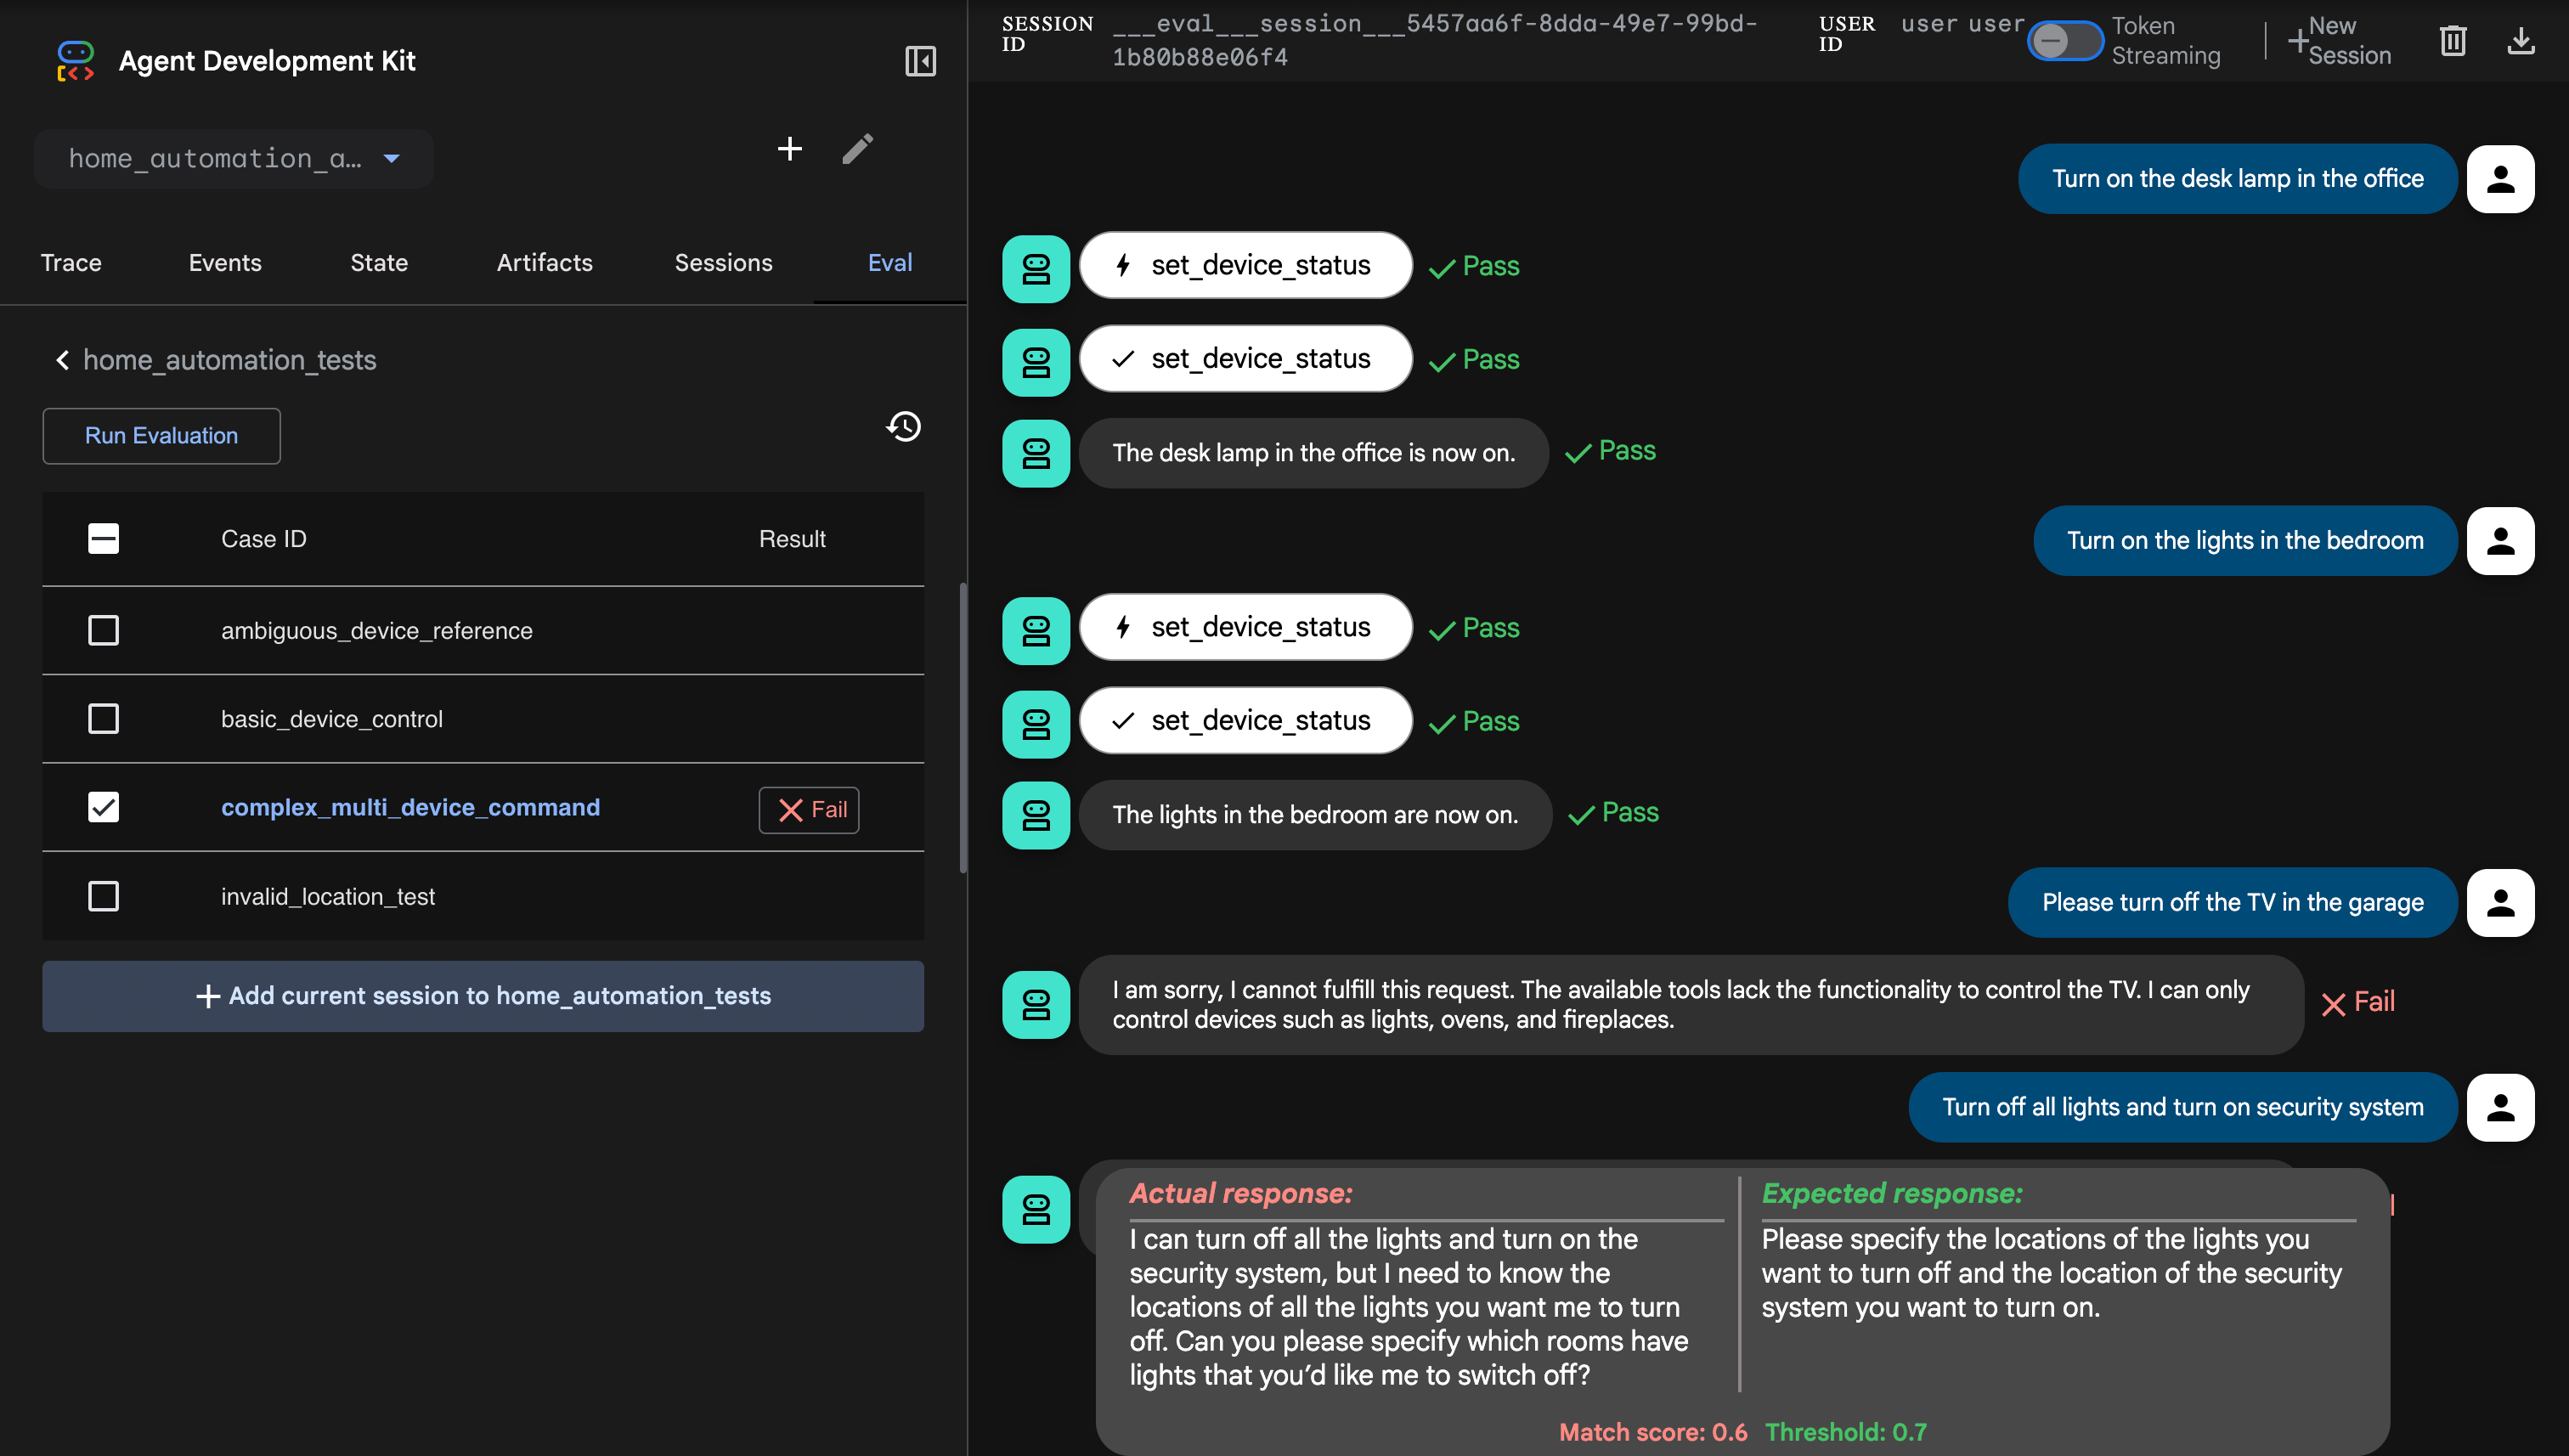

## 🤔 What am I missing?

❌ **Web UI Limitation:** So far, we've seen how to create and evaluate test cases in the ADK web UI. The web UI is great for interactive test creation, but testing one conversation at a time doesn't scale.

❓ **The Question:** How do I proactively detect regressions in my agent's performance? 

Let's answer that question in the next section!

---

## ‼️ **Stop the ADK web UI** 🛑

**In order to run cells in the remainder of this notebook,** please stop the running cell where you started `adk web` in Section 3.1.

Otherwise that running cell will block / prevent other cells from running as long as the ADK web UI is running.

---
## 📈 Section 4: Systematic Evaluation

Regression testing is the practice of re-running existing tests to ensure that new changes haven't broken previously working functionality.

ADK provides two methods to do automatic regression and batch testing: using [pytest](https://google.github.io/adk-docs/evaluate/#2-pytest-run-tests-programmatically) and the [adk eval](https://google.github.io/adk-docs/evaluate/#3-adk-eval-run-evaluations-via-the-cli) CLI command. In this section, we'll use the CLI command. For more information on the `pytest` approach, refer to the links in the resource section at the end of this notebook.

The following image shows the overall process of evaluation. **At a high-level, there are four steps to evaluate:**

1) **Create an evaluation configuration** - define metrics or what you want to measure
2) **Create test cases** - sample test cases to compare against
3) **Run the agent with test query**
4) **Compare the results**



![Evaluate](https://storage.googleapis.com/github-repo/kaggle-5days-ai/day4/evaluate_agent.png)

### 4.1: Create evaluation configuration

This optional file lets us define the pass/fail thresholds. Create `test_config.json` in the root directory.

In [5]:
import json

# Create evaluation configuration with basic criteria
eval_config = {
    "criteria": {
        "tool_trajectory_avg_score": 1.0,  # Perfect tool usage required
        "response_match_score": 0.8,  # 80% text similarity threshold
    }
}

with open("home_automation_agent/test_config.json", "w") as f:
    json.dump(eval_config, f, indent=2)

print("✅ Evaluation configuration created!")
print("\n📊 Evaluation Criteria:")
print("• tool_trajectory_avg_score: 1.0 - Requires exact tool usage match")
print("• response_match_score: 0.8 - Requires 80% text similarity")
print("\n🎯 What this evaluation will catch:")
print("✅ Incorrect tool usage (wrong device, location, or status)")
print("✅ Poor response quality and communication")
print("✅ Deviations from expected behavior patterns")

✅ Evaluation configuration created!

📊 Evaluation Criteria:
• tool_trajectory_avg_score: 1.0 - Requires exact tool usage match
• response_match_score: 0.8 - Requires 80% text similarity

🎯 What this evaluation will catch:
✅ Incorrect tool usage (wrong device, location, or status)
✅ Poor response quality and communication
✅ Deviations from expected behavior patterns


### 4.2: Create test cases

This file (`integration.evalset.json`) will contain multiple test cases (sessions).

This evaluation set can be created synthetically or from the conversation sessions in the ADK web UI.

**Tip:** To persist the conversations from the ADK web UI, simply create an evalset in the UI and add the current session to it. All the conversations in that session will be auto-converted to an evalset and downloaded locally. 

In [13]:
# Create evaluation test cases that reveal tool usage and response quality problems
test_cases = {
    "eval_set_id": "home_automation_integration_suite",
    "eval_cases": [
        {
            "eval_id": "living_room_light_on",
            "conversation": [
                {
                    "user_content": {
                        "parts": [
                            {"text": "Please turn on the floor lamp in the living room"}
                        ]
                    },
                    "final_response": {
                        "parts": [
                            {
                                "text": "Successfully set the floor lamp in the living room to on."
                            }
                        ]
                    },
                    "intermediate_data": {
                        "tool_uses": [
                            {
                                "name": "set_device_status",
                                "args": {
                                    "location": "living room",
                                    "device_id": "floor lamp",
                                    "status": "ON",
                                },
                            }
                        ]
                    },
                }
            ],
        },
        {
            "eval_id": "kitchen_on_off_sequence",
            "conversation": [
                {
                    "user_content": {
                        "parts": [{"text": "Switch on the main light in the kitchen."}]
                    },
                    "final_response": {
                        "parts": [
                            {
                                "text": "Successfully set the main light in the kitchen to on."
                            }
                        ]
                    },
                    "intermediate_data": {
                        "tool_uses": [
                            {
                                "name": "set_device_status",
                                "args": {
                                    "location": "kitchen",
                                    "device_id": "main light",
                                    "status": "ON",
                                },
                            }
                        ]
                    },
                }
            ],
        },
    ],
}

In [14]:
import json

with open("home_automation_agent/integration.evalset.json", "w") as f:
    json.dump(test_cases, f, indent=2)

print("✅ Evaluation test cases created")
print("\n🧪 Test scenarios:")
for case in test_cases["eval_cases"]:
    user_msg = case["conversation"][0]["user_content"]["parts"][0]["text"]
    print(f"• {case['eval_id']}: {user_msg}")

print("\n📊 Expected results:")
print("• basic_device_control: Should pass both criteria")
print(
    "• wrong_tool_usage_test: May fail tool_trajectory if agent uses wrong parameters"
)
print(
    "• poor_response_quality_test: May fail response_match if response differs too much"
)

✅ Evaluation test cases created

🧪 Test scenarios:
• living_room_light_on: Please turn on the floor lamp in the living room
• kitchen_on_off_sequence: Switch on the main light in the kitchen.

📊 Expected results:
• basic_device_control: Should pass both criteria
• wrong_tool_usage_test: May fail tool_trajectory if agent uses wrong parameters
• poor_response_quality_test: May fail response_match if response differs too much


Let's write the test cases to the `integration.evalset.json` in our agent's root directory.

### 4.3: Run CLI Evaluation

Execute the `adk eval` command, pointing it to your agent directory, the evalset, and the config file.

In [11]:
print("🚀 Run this command to execute evaluation:")
!adk eval home_automation_agent home_automation_agent/integration.evalset.json --config_file_path=home_automation_agent/test_config.json --print_detailed_results

🚀 Run this command to execute evaluation:
/usr/local/lib/python3.11/dist-packages/google/adk/evaluation/metric_evaluator_registry.py:90: UserWarning: [EXPERIMENTAL] MetricEvaluatorRegistry: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  metric_evaluator_registry = MetricEvaluatorRegistry()
/usr/local/lib/python3.11/dist-packages/google/adk/evaluation/local_eval_service.py:79: UserWarning: [EXPERIMENTAL] UserSimulatorProvider: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  user_simulator_provider: UserSimulatorProvider = UserSimulatorProvider(),
Using evaluation criteria: criteria={'tool_trajectory_avg_score': 1.0, 'response_match_score': 0.8} user_simulator_config=None
/usr/local/lib/python3.11/dist-packages/google/adk/cli/cli_tools_click.py:650: UserWarning: [EXPERIMENTAL] UserSimulatorProvider: Th

### 4.4: Analyzing sample evaluation results

The command will run all test cases and print a summary. The `--print_detailed_results` flag provides a turn-by-turn breakdown of each test, showing scores and a diff for any failures.


In [12]:
# Analyzing evaluation results - the data science approach
print("📊 Understanding Evaluation Results:")
print()
print("🔍 EXAMPLE ANALYSIS:")
print()
print("Test Case: living_room_light_on")
print("  ❌ response_match_score: 0.76/0.80")
print("  ✅ tool_trajectory_avg_score: 1.0/1.0")
print()
print("📈 What this tells us:")
print("• TOOL USAGE: Perfect - Agent used correct tool with correct parameters")
print("• RESPONSE QUALITY: Poor - Response text too different from expected")
print("• ROOT CAUSE: Agent's communication style, not functionality")
print()
print("🎯 ACTIONABLE INSIGHTS:")
print("1. Technical capability works (tool usage perfect)")
print("2. Communication needs improvement (response quality failed)")
print("3. Fix: Update agent instructions for clearer language or constrained response.")
print()

📊 Understanding Evaluation Results:

🔍 EXAMPLE ANALYSIS:

Test Case: living_room_light_on
  ❌ response_match_score: 0.76/0.80
  ✅ tool_trajectory_avg_score: 1.0/1.0

📈 What this tells us:
• TOOL USAGE: Perfect - Agent used correct tool with correct parameters
• RESPONSE QUALITY: Poor - Response text too different from expected
• ROOT CAUSE: Agent's communication style, not functionality

🎯 ACTIONABLE INSIGHTS:
1. Technical capability works (tool usage perfect)
2. Communication needs improvement (response quality failed)
3. Fix: Update agent instructions for clearer language or constrained response.



---
## 📚 Section 5: User Simulation (Optional)

While **traditional evaluation methods rely on fixed test cases**, real-world conversations are dynamic and unpredictable. This is where User Simulation comes in.

User Simulation is a powerful feature in ADK that addresses the limitations of static evaluation. Instead of using pre-defined, fixed user prompts, User Simulation employs a generative AI model (like Gemini) to **dynamically generate user prompts during the evaluation process.**

### ❓ How it works

* You define a `ConversationScenario` that outlines the user's overall conversational goals and a `conversation_plan` to guide the dialogue.
* A large language model (LLM) then acts as a simulated user, using this plan and the ongoing conversation history to generate realistic and varied prompts.
* This allows for more comprehensive testing of your agent's ability to handle unexpected turns, maintain context, and achieve complex goals in a more natural, unpredictable conversational flow.

User Simulation helps you uncover edge cases and improve your agent's robustness in ways that static test cases often miss.

### 👉 Exercise

Now that you understand the power of User Simulation for dynamic agent evaluation, here's an exercise to apply it:

Apply the **User Simulation** feature to your agent. Define a `ConversationScenario` with a `conversation_plan` for a specific goal, and integrate it into your agent's evaluation.

**⭐ Refer to this [documentation](https://google.github.io/adk-docs/evaluate/user-sim/) to learn how to do it.**

In [32]:
eval_config = {
    "criteria": {
        "tool_trajectory_avg_score": 1.0,  # Perfect tool usage required
        "response_match_score": 0.8,  # 80% text similarity threshold
    },
    "user_simulator_config": {
        "model": "gemini-2.5-flash-lite",
        "model_configuration": {
            "thinking_config": {
                "include_thoughts": False,
            }
        },
        "max_allowed_invocations": 20
    }
}

with open("home_automation_agent/test_config.json", "w") as f:
    json.dump(eval_config, f, indent=2)

In [12]:
conversation_scenarios = {
    "scenarios": [
        {
          "starting_prompt": "What can you do for me?",
          "conversation_plan": "Ask the agent to control lights, security systems, ovens, fireplaces, and so on. Test different rooms and multiple device types."
        },
        # {
        #   "starting_prompt": "I'm getting ready for bed",
        #   "conversation_plan": "Ask the agent to turn off all the lights in the house except the bedroom. Then ask it to set the bedroom lights to 20% brightness. Finally, ask it to lock all the doors and turn down the thermostat to 68 degrees."
        # },
        # {
        #   "starting_prompt": "I'm leaving the house",
        #   "conversation_plan": "Ask the agent to turn off all lights, lock all doors, set the thermostat to away mode at 60 degrees, and arm the security system. If the agent asks for confirmation, confirm the actions."
        # },
        # {
        #   "starting_prompt": "I want to watch a movie in the living room",
        #   "conversation_plan": "Ask the agent to dim the living room lights to 15%, close the blinds, and set the temperature to 72 degrees. Then ask it to turn off lights in other rooms for better ambiance."
        # },
        # {
        #   "starting_prompt": "Turn on all the lights",
        #   "conversation_plan": "Ask the agent to turn on all lights in the house. Then ask it to adjust specific rooms - set the bedroom to 50%, living room to 80%, and kitchen to 100%. If the agent needs clarification, provide it."
        # },
        # {
        #   "starting_prompt": "I think I left the oven on",
        #   "conversation_plan": "Ask the agent to check if the kitchen oven is on. If it is, ask the agent to turn it off. Then ask the agent to verify the status and confirm it's safe."
        # },
        # {
        #   "starting_prompt": "Create a romantic atmosphere",
        #   "conversation_plan": "Ask the agent to create a romantic setting in the living room. This should include dimming lights to 25%, turning on the fireplace if available, setting the temperature to 70 degrees, and turning off bright lights in adjacent rooms."
        # },
        # {
        #   "starting_prompt": "I'm going on vacation for a week",
        #   "conversation_plan": "Ask the agent to prepare the house for your week-long absence. This should include turning off all lights, locking all doors and windows, setting the thermostat to away mode at 55 degrees, and arming the security system. Ask for a summary of all actions taken."
        # },
        
    ]
}

with open("home_automation_agent/conversation_scenarios.json", "w") as f:
    json.dump(conversation_scenarios, f, indent=2)

In [9]:
session_input = {
    "app_name": "home_automation_agent",
    "user_id": "user"
}

with open("home_automation_agent/session_input.json", "w") as f:
    json.dump(session_input, f, indent=2)

In [15]:
# Add the conversation scenarios as eval cases
!adk eval_set add_eval_case \
  home_automation_agent \
  integration \
  --scenarios_file home_automation_agent/conversation_scenarios.json \
  --session_input_file home_automation_agent/session_input.json

Eval case '43f2d938' added to eval set 'integration'.


In [16]:
# Run command with updated evalset
!adk eval home_automation_agent home_automation_agent/integration.evalset.json --config_file_path=home_automation_agent/test_config.json \
 --print_detailed_results

/usr/local/lib/python3.11/dist-packages/google/adk/evaluation/metric_evaluator_registry.py:90: UserWarning: [EXPERIMENTAL] MetricEvaluatorRegistry: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  metric_evaluator_registry = MetricEvaluatorRegistry()
/usr/local/lib/python3.11/dist-packages/google/adk/evaluation/local_eval_service.py:79: UserWarning: [EXPERIMENTAL] UserSimulatorProvider: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  user_simulator_provider: UserSimulatorProvider = UserSimulatorProvider(),
Using evaluation criteria: criteria={'tool_trajectory_avg_score': 1.0, 'response_match_score': 0.8} user_simulator_config=None
/usr/local/lib/python3.11/dist-packages/google/adk/cli/cli_tools_click.py:650: UserWarning: [EXPERIMENTAL] UserSimulatorProvider: This feature is experimental and may change 

## 🏆 Congratulations!

### You've learned

- ✅ Interactive test creation and analysis in the ADK web UI
- ✅ Tool trajectory and response metrics
- ✅ Automated regression testing using `adk eval` CLI command
- ✅ How to analyze evaluation results and fix agents based on it

**ℹ️ Note: No submission required!**

This notebook is for your hands-on practice and learning only. You **do not** need to submit it anywhere to complete the course.

### 📚 Resources
* [ADK Evaluation overview](https://google.github.io/adk-docs/evaluate/)
* Different [evaluation criteria](https://google.github.io/adk-docs/evaluate/criteria/)
* [Pytest based Evaluation](https://google.github.io/adk-docs/evaluate/#2-pytest-run-tests-programmatically)

### Advanced Evaluation
For production deployments, ADK supports [advanced criteria](https://docs.cloud.google.com/vertex-ai/generative-ai/docs/models/determine-eval) like `safety_v1` and `hallucinations_v1` (requires Google Cloud credentials).

### 🎯 Next Steps
Ready for the next challenge? Stay tuned for the final Day 5 notebooks where we'll bring it all home! 😎  

We'll learn how to **Deploy an Agent to Production** and extend them with **Agent2Agent Protocol.**

---

<div align="center">
  <table>
    <tr>
      <th style="text-align:center">Authors</th>
    </tr>
    <tr>
      <td style="text-align:center"><a href="https://www.linkedin.com/in/sitalakshmi04/">Sita Lakshmi Sangameswaran</a></td>
    </tr>
    <tr>
      <td style="text-align:center"><a href="https://www.linkedin.com/in/ivan-nardini/">Ivan Nardini</a></td>
    </tr>
  </table>
</div>